In [1]:
import sys
import os
import numpy as np
import torch
import pandas as pd
import csv
from scipy.stats import binom
from sklearn.metrics import roc_auc_score
import torch.nn as nn

In [2]:
# custom imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from src.utils import load_config
import src.graphs_generation as graphs_gen

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\danie\Desktop\Virtual Envs\ML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model definition

## Common functions

Functions adapted from:
`\HUPLACLIP-NNs\scripts\visualizations\degree_distribution.ipynb`

In [3]:
def p_correction(p_nodes, graph_size, clique_size):
    '''Returns the value of the corrected p-value in the graph with clique ("p_reduce" case) '''
    p_corrected = (
        p_nodes * graph_size * (graph_size - 1)
        - clique_size * (clique_size - 1)
    ) / ((graph_size - clique_size) * (graph_size + clique_size - 1))
    return p_corrected

# P(d|C=0)
def p_noclique(degree_arr, graph_size):
    ''' 
    For an array of degree values (degree_arr: ndarray of shape [N_graphs, 1, graph_size]), returns the probability that (in a graph WITHOUT the clique) a node has exactly that degree.    
    Returns: ndarray of probabilities, same shape as degree_arr
    '''
    return binom.pmf(degree_arr, 
                     graph_size-1, 
                     0.5    # "p_reduce" correction only acts on graph with clique
                     )

def expected_count_noclique(degree_arr, graph_size):
    '''
    Uses p_noclique to obtain the number of nodes that (in a graph WITHOUT the clique) are expected to have exactly that degree.
    '''
    # expected count = graph_size * probability_per_node
    return graph_size * p_noclique(degree_arr, graph_size)

# P(d|C=1)
def p_ingroup(degree_arr, graph_size, clique_size, p_corrected):
    ''' 
    For an array of degree values (degree_arr: ndarray of shape [N_graphs, 1, graph_size]), returns the probability that (in a graph WITH the clique) a node INSIDE the clique has exactly that degree.    
    Returns: ndarray of probabilities, same shape as degree_arr
    '''
    return binom.pmf(degree_arr - (clique_size-1),  # number of non-clique connections
                     graph_size - clique_size,      # number of possible non-clique nodes
                     p_corrected
                     )

def p_outgroup(degree_arr, graph_size, clique_size, p_corrected):
    ''' 
    For an array of degree values (degree_arr: ndarray of shape [N_graphs, 1, graph_size]), returns the probability that (in a graph WITH the clique) a node OUTSIDE the clique has exactly that degree.    
    Returns: ndarray of probabilities, same shape as degree_arr
    '''
    return binom.pmf(degree_arr, 
                     graph_size-1, 
                     p_corrected
                     )

def expected_count_clique(degree_arr, graph_size, clique_size, p_corrected):
    '''Combines p_outgroup and p_ingroup (single mixture) to obtain the number of nodes that (in a graph WITH the clique) are expected to have exactly that degree'''
    prob = clique_size/graph_size * p_ingroup(degree_arr, graph_size, clique_size, p_corrected) + (1-clique_size/graph_size) * p_outgroup(degree_arr, graph_size, clique_size, p_corrected)    
    # expected count = graph_size * probability_per_node
    prob = graph_size * prob
    return prob

## Architecture

"Ideal MLP" designed starting from this initial sketch (11/11/2025):

![Alt text](../../scripts/Ideal-MLP_performance/whiteboard_images/Ideal-MLP-sketch.jpg)

More complete diagram (17/11/2025):

![Alt text](../../scripts/Ideal-MLP_performance/whiteboard_images/Zoom-Meeting_2025-11-17_Ideal-MLP_architecture.png)

In [22]:
class Ideal_MLP(nn.Module):
    
    # NOTE possible improvements:
    # - handle with actual bins (now n_bins = N)
    # - standardization before comparing clique/no clique
    # - "left" and "right" blocks can be simplified?
    
    def __init__(self, graph_size:int, max_clique_prop:float = 0.7):
        super().__init__()
        self.N = graph_size
        
        # Precomputing variables:
        print("Precomputing variables...")
        # - array of bin edges: 
        self.tau = torch.arange(0, self.N+1) #NOTE: possible improvement is extending this to actual bins spanning more than 1 single value
        #print("Tau values: ", self.tau)
        # - array of clique size values:
        max_K = int(max_clique_prop * self.N)
        self.clique_size_values = torch.arange(1, max_K + 1)
        #print("Clique size values: ", self.clique_size_values)
        # - compute expected histograms and store as torch.float32 tensors
        self.expected_hist_no_clique = torch.tensor(
            expected_count_noclique(self.tau, self.N), dtype=torch.float32
        )  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts
        expected_hist_clique = []
        for K in self.clique_size_values:
            p_corrected = p_correction(0.5, self.N, K)
            expected_hist_K = expected_count_clique(self.tau, self.N, K, p_corrected)  # shape: (len_tau, 1) NOTE: these should sum to N given that they are expected counts
            expected_hist_clique.append(torch.tensor(expected_hist_K, dtype=torch.float32))
        self.expected_hist_clique = torch.stack(expected_hist_clique, dim=1)  # shape: (len_tau, len_clique_size_values)        
        print("Completed precomputing variables...")
        
    # Processing blocks:
    def forward(self, adj_matrices: torch.Tensor):
        '''
        Input: adj_matrices of shape [batch_size, 1, N, N]
        Output: tensor of shape [batch_size] (softmaxed score for no-clique (0) and clique (1) cases)
        '''
        if(adj_matrices.shape[2] != self.N):
            raise ValueError(f"Input graphs have size {adj_matrices.shape[2]}, but model was initialized for size {self.N}")
                    
        # compute degree of each node (sum over rows)
        degrees = torch.sum(adj_matrices, dim=2)  # shape: (batch_size, 1, N)
        degrees = degrees.squeeze(1)  # shape: (batch_size, N)
        
        # Vectorized: degrees shape (batch_size, N)
        batch_size, N = degrees.shape
        len_tau = len(self.tau)

        # cast tau to same dtype/device and reshape for broadcasting:
        tau_val = self.tau.to(dtype=degrees.dtype, device=degrees.device).view(1, len_tau, 1)  # shape: (1, len_tau, 1)
        deg_batched = degrees.view(batch_size, 1, N)  # shape: (batch_size, 1, N)

        # "left" block (broadcasts to (batch_size, len_tau, N))
        x_left = torch.relu(deg_batched - (tau_val - 2.0))
        x_left = torch.relu(2.0 - x_left)
        left = x_left - torch.relu(x_left - 1.0)

        # "right" block (broadcasts to (batch_size, len_tau, N))
        x_right = torch.relu(2.0 - torch.relu(deg_batched - (tau_val - 1.0)))
        right = x_right - torch.relu(x_right - 1.0)

        # indicator matrix per graph: (batch_size, len_tau, N)
        degree_indicator_matrices = (right - left)  # float tensor with 0/1 values
        degree_indicator_matrices = (degree_indicator_matrices > 0.5).long()    # convert to int 0/1 values

        # summing over nodes to get raw histograms:
        raw_histograms = degree_indicator_matrices.sum(dim=2)  # shape (batch_size, len_tau)
        #print("raw histograms shape:", raw_histograms.shape)                
        
        # computing differences with expected histograms:
        # - no clique case:
        #print("expected hist no clique dtype:", self.expected_hist_no_clique.dtype)
        expected_no_clique = self.expected_hist_no_clique.to(dtype=degrees.dtype, device=degrees.device).view(1, len_tau)  # shape: (1, len_tau)
        diff_no_clique = torch.abs(raw_histograms - expected_no_clique)  # shape: (batch_size, len_tau)
        mean_diff_no_clique = torch.mean(diff_no_clique, dim=1)  # shape: (batch_size,)  
        # - clique case (per-clique-size differences, then average across clique sizes):
        #   - expected hist:
        expected_clique = self.expected_hist_clique.to(dtype=degrees.dtype, device=degrees.device)  # move to same dtype and device
        expected_clique = expected_clique.unsqueeze(0)  # add batch dimension: (1, len_tau, num_K)
        #   - raw_hist:
        raw_expanded = raw_histograms.unsqueeze(2)  # add clique-size dim for broadcasting: (batch_size, len_tau, 1)
        diff_clique_per_tau = torch.abs(raw_expanded - expected_clique)  # elementwise absolute difference per graph, per tau, per clique-size: (batch_size, len_tau, num_K)
        diff_clique_per_K = torch.mean(diff_clique_per_tau, dim=1)  # aggregate across tau to get one difference value per graph per clique-size (batch_size, num_K)
        # Choose the best-fitting clique size K (min error) per graph, to avoid underestimating the 'clique' probability through averaging:
        mean_diff_clique = torch.mean(diff_clique_per_K, dim=1)  # (batch_size,)
        
        # computing final decision for each graph (a smaller difference means a higher likelikood of that class)
        logits = mean_diff_no_clique - mean_diff_clique  # shape: (batch_size,): positive -> more likely clique, negative -> more likely no-clique
        probs = torch.sigmoid(logits)  # shape: (batch_size,) -> probability of responding "clique"
        #print("output probs shape:", probs.shape)
        print("output probs:", probs)
        return probs


Clique size of:  300  in a graph of size:  600


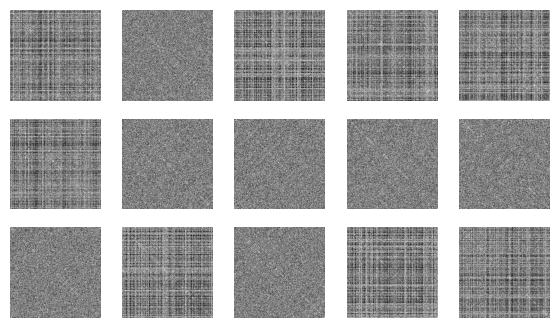

Precomputing variables...


C:\Users\danie\AppData\Local\Temp\ipykernel_21664\1971246833.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_clique.append(torch.tensor(expected_hist_K, dtype=torch.float32))


Completed precomputing variables...
output probs: tensor([0.5818, 0.2359, 0.5850, 0.5839, 0.5836, 0.5829, 0.2351, 0.2333, 0.2345,
        0.2453, 0.2280, 0.5839, 0.2397, 0.5811, 0.5813])
Hard outputs:  [1 0 1 1 1 1 0 0 0 0 0 1 0 1 1]
Labels:  [1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
Fraction of correct responses:
1.0


In [24]:
import matplotlib.pyplot as plt

# test of model on task instance
N_value = 600   #CHANGE THIS
clique_size_fraction = 0.5 # CHANGE THIS
print("Clique size of: ", int(clique_size_fraction*N_value), " in a graph of size: ", N_value)
# visualizing input for 15 graphs, "p_reduce"
graphs_with_clique = graphs_gen.generate_batch(15, N_value, np.repeat([int(clique_size_fraction*N_value)],15), "p_reduce", False)
# Show 15 graphs
fig, axes = plt.subplots(3, 5, figsize=(7, 4))
for i in range(15):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(np.squeeze(graphs_with_clique[0][i]), cmap='gray_r')
    axes[row, col].axis('off')
plt.show()
# testing ideal MLP on this graph:
ideal_MLP = Ideal_MLP(N_value)
soft_output = ideal_MLP(graphs_with_clique[0])
hard_output = (soft_output >= 0.5).long().cpu().numpy()  # threshold at 0.5
print("Hard outputs: ", hard_output)
print("Labels: ", graphs_with_clique[1])

print("Fraction of correct responses:")
print(np.sum(hard_output == graphs_with_clique[1]) / 15)

# Test function

In [9]:
# read configuration file:
config = load_config(
    os.path.join("Ideal-MLP_test_config.yml")
)  # CHANGE THIS TO PERFORM DIFFERENT EXPERIMENTS

# looping over the different graph sizes in the experiment:
for graph_size in config["graph_size_values"]:
    
    ideal_MLP = Ideal_MLP(graph_size).to(device)

    # Create empty dictionaries for storing testing results:
    fraction_correct_results = {}  # Fraction correct for each clique size
    metrics_results_list = []

    # Calculate max clique size for testing (proportion of graph size):
    max_clique_size_proportion_test = config["testing_parameters"]["max_clique_size_proportion_test"]
    max_clique_size = int(
        max_clique_size_proportion_test * graph_size
    )

    # Calculate array of clique sizes for all test curriculum
    # NOTE: if max clique size is smaller than the the number of test levels, use max clique size as the number of test levels
    clique_sizes = np.linspace(
        max_clique_size,
        1,
        num=min(max_clique_size, config["testing_parameters"]["clique_testing_levels"]),
    ).astype(int)
    
    # Metrics initialization
    TP, FP, TN, FN = 0, 0, 0, 0  
    y_scores = []
    y_true = []    

    # Loop for decreasing clique sizes
    for current_clique_size in clique_sizes:

        # Initialize fraction correct list, updated at each test iteration
        fraction_correct_list = []

        # Loop for testing iterations:
        for test_iter in range(config["testing_parameters"]["test_iterations"]):

            # Generate clique size value of each graph in the current batch
            clique_size_array_test = graphs_gen.generate_batch_clique_sizes(
                np.array([current_clique_size]),
                config["testing_parameters"]["num_test"],
            )

            # Generate validation graphs
            test = graphs_gen.generate_batch(
                config["testing_parameters"]["num_test"],
                graph_size,
                clique_size_array_test,
                config["p_correction_type"],
                False,
            )
            
            # Perform prediction on test data
            soft_output = ideal_MLP(test[0]).squeeze()
            hard_output = (soft_output >= 0.5).int().cpu().numpy()  # converting to hard output (0/1)
            # print(hard_output.shape, test_labels.shape)   # DEBUGGING

            # Update global metrics for AUC-ROC
            y_scores.extend(soft_output.cpu().tolist())
            labels = test[1]
            y_true.extend(list(labels))
             
            # transforming hard_output and test_labels to torch tensors:
            hard_output = torch.tensor(hard_output, dtype=torch.float32)
            test_labels = torch.tensor(test[1], dtype=torch.float32)
            
            # DEBUGGING:
            print("Soft outputs: ", soft_output)
            print("Hard outputs: ", hard_output)
            print("Test labels: ", test_labels)
            
            # Compute metrics
            TP += ((hard_output == 1) & (test_labels == 1)).sum().item()
            FP += ((hard_output == 1) & (test_labels == 0)).sum().item()
            TN += ((hard_output == 0) & (test_labels == 0)).sum().item()
            FN += ((hard_output == 0) & (test_labels == 1)).sum().item()

            # updating fraction correct list with the accuracy of the current test iteration:
            fraction_correct_list.append(
                (hard_output == test_labels).sum().item()
                / (1.0 * config["testing_parameters"]["num_test"])
            )
            
            # delete unused variables
            del test, hard_output, test_labels, clique_size_array_test, soft_output
            torch.cuda.empty_cache()

        # Updating dictionary after all test iterations for current clique size have been completed:
        fraction_correct_results[current_clique_size] = round(
            sum(fraction_correct_list) / len(fraction_correct_list), 2
        )

        # Printing the size of the clique just tested and the corresponding test accuracy:
        print(
            f"||| Completed testing for clique = {current_clique_size}. "
            f"Average fraction correct = {fraction_correct_results[current_clique_size]}"
        )
        print("|||===========================================================")

    # - notify completion of testing:
    print(f"| Finished testing Ideal MLP at N = {graph_size}.")

    # Computing metrics:
    precision = TP / (TP + FP + 1e-10)
    recall = TP / (TP + FN + 1e-10)
    F1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    AUC_ROC = roc_auc_score(y_true, y_scores)
    num_params = sum(
        p.numel() for p in ideal_MLP.parameters()
    )  # storing total number of parameters
    metrics_results = {
        "TP": TP,
        "FP": FP,
        "TN": TN,
        "FN": FN,
        "precision": precision,
        "recall": recall,
        "F1": F1,
        "AUC_ROC": AUC_ROC,
        "total_params": num_params,
    }

    # Saving accuracy results in .csv file:
    # - defining file name and path:
    file_path = os.path.join(
        os.getcwd(), "results", f"Ideal-MLP_N{graph_size}_fraction_correct_1.csv"
    )
    # - saving the dictionary as a .csv file:
    with open(file_path, "w") as file:
        writer = csv.writer(file)
        writer.writerow(["clique size", "fraction correct"])  # Add column labels
        for key, value in fraction_correct_results.items():
            writer.writerow([key, value])
    # Saving metrics results in .csv file:
    # - defining file name and path:
    file_path = os.path.join(
        os.getcwd(), "results", f"Ideal-MLP_N{graph_size}_metrics_1.csv"
    )
    # - saving the dictionary as a .csv file:
    pd.DataFrame([metrics_results]).to_csv(file_path, index=False)

    print(f"- Ideal MLP Results saved successfully for N = {graph_size}.")

Configuration file loaded successfully.
Precomputing variables...
Completed precomputing variables...
Soft outputs:  tensor([0.8547, 0.5032, 0.8529, 0.5000, 0.8641, 0.5001, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5022, 0.5002, 0.8575, 0.5003, 0.8446, 0.8485, 0.8544, 0.8598,
        0.5003, 0.8557, 0.5025, 0.8589, 0.8553, 0.8577, 0.5000, 0.8442, 0.8544,
        0.8633, 0.5000, 0.5004, 0.5000, 0.5003])
Hard outputs:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Test labels:  tensor([1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1.,
        0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.])
Soft outputs:  tensor([0.5000, 0.8305, 0.8531, 0.8500, 0.5000, 0.5000, 0.5000, 0.5000, 0.5004,
        0.5000, 0.5000, 0.5099, 0.5005, 0.8658, 0.8637, 0.5016, 0.5003, 0.8440,
        0.8676, 0.8574, 0.8521, 0.5035, 0.8397, 0.5009, 0.8587, 0.5000, 0.5004,
        0.8445, 0.50

C:\Users\danie\AppData\Local\Temp\ipykernel_21664\2898706557.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_hist_clique.append(torch.tensor(expected_hist_K, dtype=torch.float32))


Soft outputs:  tensor([0.5000, 0.8415, 0.5000, 0.5000, 0.8404, 0.8401, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5002, 0.5000, 0.5000, 0.5000, 0.8467, 0.5001, 0.8315, 0.8467,
        0.5000, 0.5000, 0.8460, 0.8317, 0.5000, 0.8406, 0.8472, 0.8444, 0.8432,
        0.5001, 0.5000, 0.5000, 0.5000, 0.5000])
Hard outputs:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Test labels:  tensor([0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
        0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.])
Soft outputs:  tensor([0.5000, 0.8470, 0.8527, 0.8435, 0.5000, 0.5000, 0.8397, 0.8405, 0.8354,
        0.5001, 0.8444, 0.8349, 0.5000, 0.5000, 0.5000, 0.5000, 0.5053, 0.5000,
        0.5000, 0.8411, 0.8519, 0.5000, 0.5000, 0.8407, 0.8468, 0.8387, 0.8296,
        0.5000, 0.8295, 0.8564, 0.8464, 0.5001])
Hard outputs:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.